## Data Modelling notebook

In [39]:
# Data and Numbers
import pandas as pd
import numpy as np
import datetime as dt

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from six import StringIO
#from sklearn.externals.six import StringIO
from xgboost import XGBClassifier

# Saving
import pickle

In [40]:
#pip install six

### Reading the cleaned CSV

In [41]:
final_df = pd.read_csv('final.csv')

The cleaned CSV file contain the following columns,

- cat_new - Contains the categories of the industry ('biotech', 'healthcare', 'medical devices', 'medical/pharma')
- funding_total_usd - Total funding (USD)
- funding_rounds - Total funding rounds	
- homepage_url_new - If the startup contains URL or not	
- Region - In which region the startup is, only USA ('Midwest', 'Northeast', 'South', 'West')
- investor_name - Count of the investors
- avg_raise_usd - Average raised USD
- avg_time_bw_rounds_float - Average time between two rounds (more than two rounds)
- time_bw_first_rounds_float - Time between the first round
- status_new - The target column, if the startup succeded or not

In [42]:
final_df.head()

,Unnamed: 0,company_name,category_list,funding_total_usd,status,country_code,state_code,funding_rounds,first_funding_at,last_funding_at,homepage_url_new,time_bw_first_rounds,avg_time_bw_rounds,avg_raised_usd,avg_time_bw_rounds_float,time_bw_first_rounds_float,status_new,investor_count,cat_new,Region
0,0,1-800-DENTIST,health and wellness,100000.0,operating,USA,CA,1,2010-08-19,2010-08-19,1,0 days 00:00:00.000000000,NaN,21732739.24,0.0,0,0,2.0,healthcare,West
1,1,1-800-DOCTORS,health and wellness,1750000.0,operating,USA,NJ,1,2011-03-02,2011-03-02,1,0 days 00:00:00.000000000,NaN,1750000.00,0.0,0,0,1.0,healthcare,Northeast
2,2,Redox,health care|health care information technology...,4000000.0,operating,USA,WI,2,2014-11-26,2015-10-20,1,328 days 00:00:00.000000000,328 days 00:00:00.000000000,2000000.00,328.0,328,1,6.0,healthcare,Midwest
3,3,10X Genomics,biotechnology|technology,55000000.0,operating,USA,CA,1,2015-01-12,2015-01-12,1,0 days 00:00:00.000000000,NaN,55000000.00,0.0,0,1,3.0,biotech,West
4,4,10X Technologies,biotechnology,3550000.0,operating,USA,CA,2,2012-11-07,2015-01-12,1,796 days 00:00:00.000000000,796 days 00:00:00.000000000,1775000.00,796.0,796,1,1.0,biotech,West


Label encoding the categorical columns, cat_new column-which has categories of industries and Region columns contain the region where the startup is.

In [43]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [44]:
final_df['cat'] = le.fit_transform(final_df['cat_new'])

In [45]:
list(le.classes_)

['biotech', 'healthcare', 'medical devices', 'medical/pharma']

In [46]:
final_df['region'] = le.fit_transform(final_df['Region'])

In [47]:
list(le.classes_)

['Midwest', 'Northeast', 'South', 'West']

In [48]:
# final_df.drop(['cat_new','Region'],axis = 1, inplace=True)

In [49]:
final_df.columns

Index(['Unnamed: 0', 'company_name', 'category_list', 'funding_total_usd',
       'status', 'country_code', 'state_code', 'funding_rounds',
       'first_funding_at', 'last_funding_at', 'homepage_url_new',
       'time_bw_first_rounds', 'avg_time_bw_rounds', 'avg_raised_usd',
       'avg_time_bw_rounds_float', 'time_bw_first_rounds_float', 'status_new',
       'investor_count', 'cat_new', 'Region', 'cat', 'region'],
      dtype='object')

In [50]:
final_df[final_df['region']==2]

,Unnamed: 0,company_name,category_list,funding_total_usd,status,country_code,state_code,funding_rounds,first_funding_at,last_funding_at,...,avg_time_bw_rounds,avg_raised_usd,avg_time_bw_rounds_float,time_bw_first_rounds_float,status_new,investor_count,cat_new,Region,cat,region
10,10,Babyscripts,health and wellness|mobile health,2100000.0,operating,USA,DC,3,2013-03-11,2015-04-10,...,380 days 00:00:00.000000000,7.000000e+05,380.0,287,1,4.0,healthcare,South,1,2
12,12,20/20 Gene Systems Inc.,biotechnology|health diagnostics,4345427.0,operating,USA,MD,3,2012-09-25,2015-10-30,...,565 days 00:00:00.000000000,1.448476e+06,565.0,1093,1,1.0,healthcare,South,1,2
13,13,21st Century Oncology,health and wellness,325000000.0,operating,USA,FL,1,2014-09-26,2014-09-26,...,NaN,3.250000e+08,0.0,0,1,1.0,healthcare,South,1,2
19,19,360imaging,biotechnology|dental,1000000.0,operating,USA,GA,2,2011-11-01,2013-01-01,...,427 days 00:00:00.000000000,5.000000e+05,427.0,427,0,1.0,biotech,South,0,2
22,22,"3D Operations, Inc.",3d printing|health and wellness|health care,7500.0,operating,USA,TN,1,2014-05-15,2014-05-15,...,NaN,7.500000e+03,0.0,0,1,1.0,healthcare,South,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6945,6945,ZS Pharma,biotechnology,122987972.0,acquired,USA,TX,5,2010-12-14,2014-07-18,...,328 days 00:00:00.000000000,2.459759e+07,328.0,6,1,10.0,biotech,South,0,2
6948,6948,zumatek,biotechnology,150000.0,operating,USA,NC,1,2010-11-23,2010-11-23,...,NaN,1.500000e+05,0.0,0,0,1.0,biotech,South,0,2
6949,6949,Zumba Fitness,health and wellness,100000.0,operating,USA,FL,1,2012-03-08,2012-03-08,...,NaN,2.173274e+07,0.0,0,0,2.0,healthcare,South,1,2
6954,6954,Zymetis,biotechnology,2257464.0,closed,USA,MD,3,2007-01-01,2010-01-31,...,563 days 00:00:00.000000000,1.128732e+06,563.0,1106,0,2.0,biotech,South,0,2


## Modelling

Splitting the data for the train test split

In [51]:
X = final_df[['funding_total_usd', 'funding_rounds', 'time_bw_first_rounds_float','avg_raised_usd', 'avg_time_bw_rounds_float',
              'investor_count','cat','region','homepage_url_new']]

y = final_df[['status_new']]

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [53]:
X_train[X_train['cat']==0]

,funding_total_usd,funding_rounds,time_bw_first_rounds_float,avg_raised_usd,avg_time_bw_rounds_float,investor_count,cat,region,homepage_url_new
1034,40664199.0,7,961,5.809171e+06,293.0,9.0,0,1,1
5704,42027500.0,13,163,3.232885e+06,130.0,7.0,0,1,1
1752,2350479.0,1,0,2.350479e+06,0.0,1.0,0,1,0
976,13600000.0,3,1143,1.360000e+07,571.0,6.0,0,0,1
3010,28391902.0,5,852,7.097976e+06,848.0,5.0,0,2,1
...,...,...,...,...,...,...,...,...,...
5618,150000.0,1,0,1.500000e+05,0.0,1.0,0,1,0
5881,73000000.0,2,564,3.650000e+07,564.0,13.0,0,1,1
1109,71798.0,1,0,7.179800e+04,0.0,1.0,0,1,1
2391,5585000.0,5,350,1.117000e+06,197.0,1.0,0,3,1


### Standard Scaling

Scaling the data in by using StandardScaler for only the X_train and X_test split as y_train and y_test has the values of 0 and 1

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

### Accuracy Function

This function calculates the test and train accuracy

In [56]:
def pred_models_scaled(x_trn, y_trn, x_tst, y_tst):
    logreg = LogisticRegression()
    svm_model = svm.SVC()
    xgb = XGBClassifier()
    rf = RandomForestClassifier()
    
    l = logreg.fit(x_trn,y_trn)
    s = svm_model.fit(x_trn,y_trn)
    x = xgb.fit(x_trn,y_trn)
    r = rf.fit(x_trn,y_trn)
    
    l_pred = l.predict(x_tst)
    s_pred = s.predict(x_tst)
    x_pred = x.predict(x_tst)
    r_pred = r.predict(x_tst)
    
    
    acc_scl= {'model':['logreg','svc','xgb','rf'], 
              'tst_scr':[accuracy_score(y_tst,l_pred),accuracy_score(y_tst,s_pred),accuracy_score(y_tst,x_pred),accuracy_score(y_tst,r_pred)],
              'trn_acc':[accuracy_score(y_trn, l.predict(x_trn)),accuracy_score(y_trn, s.predict(x_trn)),accuracy_score(y_trn, x.predict(x_trn)),accuracy_score(y_trn, r.predict(x_trn))]}
    acc_scl = pd.DataFrame(data= acc_scl)
    
    return acc_scl

In [57]:
scl = pred_models_scaled(X_train_scaled,y_train,X_test_scaled,y_test)
scl

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-56-22b4a88822ad>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r = rf.fit(x_trn,y_trn)


,model,tst_scr,trn_acc
0,logreg,0.686063,0.700916
1,svc,0.688937,0.704509
2,xgb,0.664511,0.829352
3,rf,0.688937,0.939644


From the above dataframe we see that logistic regression, SVM classifier and XGBoost are models that we can consider and tune it. Random forest algorithm we cannot consider it, as the test accuracy should be more, as we have defined the model for the same. We will find out more paramters and choose the algorithm.

### ROC Curve function
This function helps to find out the region under the curve.

In [58]:
def preds(x_trn, y_trn, x_tst, y_tst):
    logreg = LogisticRegression()
    svm_model = svm.SVC()
    xgb = XGBClassifier()
    rf = RandomForestClassifier()
    
    l = logreg.fit(x_trn,y_trn)
    s = svm_model.fit(x_trn,y_trn)
    x = xgb.fit(x_trn,y_trn)
    r = rf.fit(x_trn,y_trn)
    
    l_pred = l.predict(x_tst)
    s_pred = s.predict(x_tst)
    x_pred = x.predict(x_tst)
    r_pred = r.predict(x_tst)
    
    return l_pred,s_pred,x_pred,r_pred

In [59]:
l_pred,s_pred,x_pred,r_pred = preds(X_train_scaled,y_train,X_test_scaled,y_test)

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-58-05cac56e9606>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r = rf.fit(x_trn,y_trn)


In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

fpr_l, tpr_l, thresh_l = metrics.roc_curve(y_test.status_new,l_pred)
auc_l = metrics.roc_auc_score(y_test.status_new,l_pred)

fpr_s, tpr_s, thresh_s = metrics.roc_curve(y_test.status_new,s_pred)
auc_s = metrics.roc_auc_score(y_test.status_new,s_pred)

fpr_x, tpr_x, thresh_x = metrics.roc_curve(y_test.status_new,x_pred)
auc_x = metrics.roc_auc_score(y_test.status_new,x_pred)

fpr_r, tpr_r, thresh_r = metrics.roc_curve(y_test.status_new,r_pred)
auc_r = metrics.roc_auc_score(y_test.status_new,r_pred)

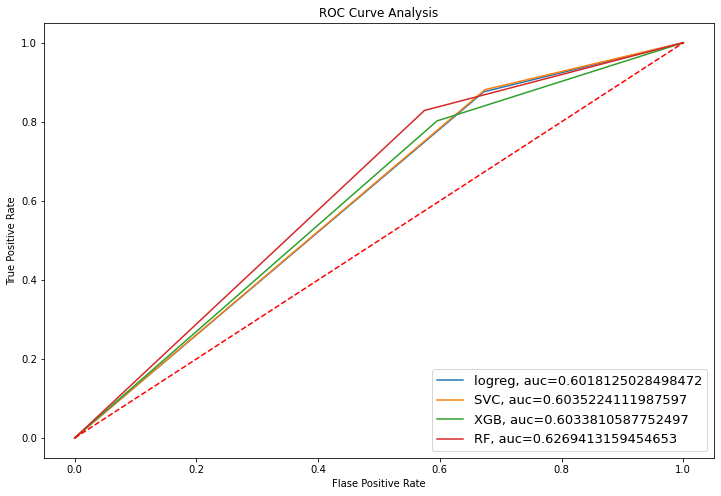

In [61]:
#roc curve
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(fpr_l,tpr_l,label="logreg, auc="+str(auc_l))
plt.plot(fpr_s,tpr_s,label="SVC, auc="+str(auc_s))
plt.plot(fpr_x,tpr_x,label="XGB, auc="+str(auc_x))
plt.plot(fpr_r,tpr_r,label="RF, auc="+str(auc_r))
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("Flase Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve Analysis')
plt.legend(prop={'size':13}, loc='lower right')

From above the AUC we get maximum for random forest.

### Fbeta Score

The F-beta score weights recall more than precision by a factor of beta,

Weigh recall more heavily than precision because in the case of venture capital investments, it is worse to miss out on a potential unicorn investment (10-100X return) (type II error - false negative) than to invest in a dud (1X loss) (type 1 error - false positive), however we won't place all weight on recall as it is still valuable for a VC firm to distinguish itself by reducing the amount of "duds" it invests in.

If viewing from the prospective of a founder, they would prioritize precision since starting a company requires a lot of time and effort, they want to really improve the likelihood of starting a successful company.

In [62]:
from sklearn.metrics import fbeta_score

def fbeta_scaled(x_trn, y_trn, x_tst, y_tst):
    logreg = LogisticRegression()
    svm_model = svm.SVC()
    xgb = XGBClassifier()
    rf = RandomForestClassifier()
    
    l = logreg.fit(x_trn,y_trn)
    s = svm_model.fit(x_trn,y_trn)
    x = xgb.fit(x_trn,y_trn)
    r = rf.fit(x_trn,y_trn)
    
    l_pred = l.predict(x_tst)
    s_pred = s.predict(x_tst)
    x_pred = x.predict(x_tst)
    r_pred = r.predict(x_tst)
    
    l_fbeta = fbeta_score(y_tst,l_pred,3)
    s_fbeta = fbeta_score(y_tst,s_pred,3)
    x_fbeta = fbeta_score(y_tst,x_pred,3)
    r_fbeta = fbeta_score(y_tst,r_pred,3)
    
    fb_scl= {'model':['logreg','svc','xgb','rf'], 
              'fb_scr':[l_fbeta,s_fbeta,x_fbeta,r_fbeta]}
    fb_scl = pd.DataFrame(data= fb_scl)
    
    return fb_scl

In [63]:
fbeta_scaled(X_train_scaled,y_train,X_test_scaled,y_test)

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-62-12d648d40d02>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r = rf.fit(x_trn,y_trn)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,model,fb_scr
0,logreg,0.855977
1,svc,0.860792
2,xgb,0.792875
3,rf,0.819868


Considering all the three factors, accuracy, AUC and f-beta score, we decided to hypertune XGBoost and Logistic regresion algorithms.

#### Tunning XGBoost

In [64]:
model_xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=10, 
                      gamma=10)

x = model_xgb.fit(X_train_scaled,y_train)
x_pred = x.predict(X_test_scaled)

test_acc = accuracy_score(y_test,x_pred)
train_acc = accuracy_score(y_train, model_xgb.predict(X_train_scaled))
           
print('Test acc: {} and Train acc: {}'.format(test_acc, train_acc))

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[19:33:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Test acc: 0.6853448275862069 and Train acc: 0.7025327824681157


In [65]:
auc_x = metrics.roc_auc_score(y_test.status_new,x_pred)
auc_x

0.5880899183803748

#### Tunning Logitstic Regression

In [66]:
lr_reg = LogisticRegression(solver='saga',
                            C=0.1)

l = lr_reg.fit(X_train_scaled, y_train)
l_pred = l.predict(X_test_scaled)

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [67]:
auc_x = metrics.roc_auc_score(y_test.status_new,l_pred)
auc_x

0.6023619533992978

In [68]:
test_acc = accuracy_score(y_test,l_pred)
train_acc = accuracy_score(y_train, l.predict(X_train_scaled))
           
print('Test acc: {} and Train acc: {}'.format(test_acc, train_acc))

Test acc: 0.6867816091954023 and Train acc: 0.7007364828453386


From the accuracies and area under the curve outputs we decided to go with the Logistic regression.

In [69]:
# Look at coefficients
lr_reg_coefs = pd.DataFrame(sorted(list(zip(X.columns, lr_reg.coef_[0])),
                                   key=(lambda x: x[1]),
                                   reverse=True),
                            columns=['Feature', 'Coefficient'])
lr_reg_coefs

,Feature,Coefficient
0,funding_rounds,0.500462
1,cat,0.495973
2,avg_time_bw_rounds_float,0.342154
3,investor_count,0.266238
4,homepage_url_new,0.215222
5,funding_total_usd,0.159243
6,avg_raised_usd,0.136584
7,region,-0.028571
8,time_bw_first_rounds_float,-0.076385


In [70]:
lr_reg_coefs.to_csv('log_coeff.csv')

In [71]:

# Intercept
lr_reg.intercept_[0]

0.7931287297950361

In [72]:
# convert intercept log-odds to probability
logodds = lr_reg.intercept_[0]
odds = np.exp(logodds)
prob = odds / (1 + odds)
# prob[0]
print('All else considered, companies that make it past their first funding round, probability of success is {:.2f}%'.format(100 * prob))

All else considered, companies that make it past their first funding round, probability of success is 68.85%


## Saving the pickel file

We created a pickle file for both the model and the standard scaler as we will be needing it in the flask application.

In [73]:
import pickle as pickle

In [74]:
import pickle
with open("scaler_sel.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [75]:
import pickle
with open("lr_reg.pkl", "wb") as f:
    pickle.dump(lr_reg, f)